Error minimizing using different values of angle per increment for each encoder

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from tqdm import tqdm
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
# from support.omniwheel_calculation_pd import *
from support.omniwheel_calculation import *
from datetime import datetime
from support.pd_support import *
from support.calculations_support import *
from support.ar_calculations import *
from numba import njit
import polars as pl
from support.imu_calculations import *
from scipy import integrate

# %matplotlib widget
# import ipywidgets as widgets


In [97]:
_parent_folder = "omni_9dof_april_25_2023"
_folder_name = "sk33_00_rotation_01"
_base_pth = os.path.dirname(os.getcwd())
_base_pth = os.path.dirname(_base_pth)
_base_pth = os.path.join(_base_pth,"recording_programs", "test_data", _parent_folder)
_base_pth

# C:\Users\CMC\Documents\openposelibs\pose\armbo\recording_programs\test_data\omni_9dof_april_20_2023\sk32_00_test_slow_00\imu01.csv

'c:\\Users\\CMC\\Documents\\openposelibs\\pose\\armbo\\recording_programs\\test_data\\omni_9dof_april_25_2023'

In [98]:
_sk_df = pd.read_csv(os.path.join(_base_pth, _folder_name, "imu01.csv"))
_sk_df["rust_time"] = _sk_df["rust_time"].apply(lambda x: datetime.fromtimestamp(x))
# rename columns
_sk_df.rename(columns={"rust_time": "time", "e_fr":"e_t"}, inplace=True)
_sk_df["e_t"] =  _sk_df["e_t"]
_sk_df["e_rr"] = -_sk_df["e_rr"]
_sk_df["e_rl"] = -_sk_df["e_rl"]

In [99]:
_imu_df = _sk_df[["time", "ax", "ay", "az", "gx", "gy", "gz", "mx", "my", "mz"]]


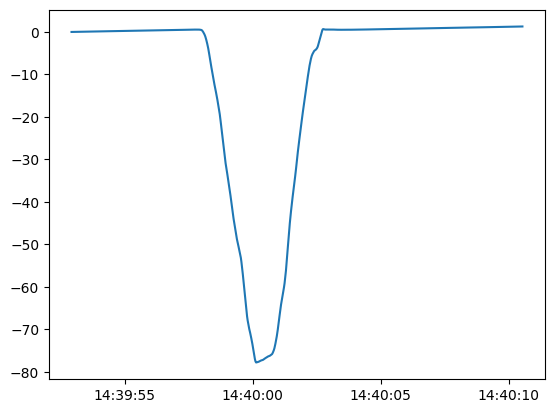

In [100]:
plt.plot(_imu_df["time"], _imu_df["gz"].cumsum() * 0.005 * 9.8)

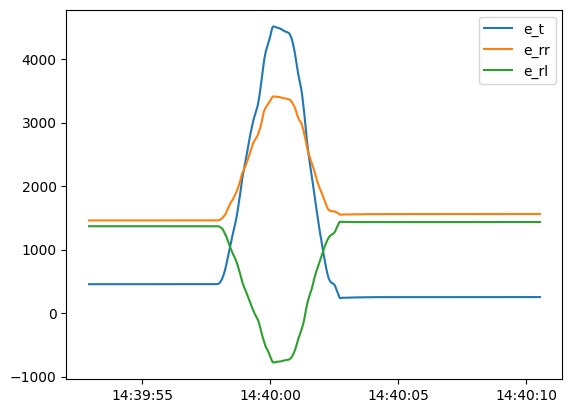

In [101]:
plt.plot(_sk_df["time"], _sk_df["e_t"], label="e_t")
plt.plot(_sk_df["time"], _sk_df["e_rr"], label="e_rr")
plt.plot(_sk_df["time"], _sk_df["e_rl"], label="e_rl")
plt.legend()


In [102]:
def get_dir_vel(df, ang_col, radius=radius, x = x, y = y, mocap_ang = None):
    inst = True

    if not isinstance(df, pl.DataFrame):
        df = pl.from_pandas(df)
        inst = False 

    column_name = ang_col
    my_dict = {"_vx":[],"_vy":[],"_w":[]}

    for i in range(len(df)):

        mat = np.array([[np.cos(mocap_ang[i])/radius, -np.sin(mocap_ang[i])/radius, 0], 
                        [-np.sin(mocap_ang[i])/radius, np.cos(mocap_ang[i])/radius, 0], 
                        [-np.sin(mocap_ang[i])/radius, np.cos(mocap_ang[i])/radius, 0],
                        [0, 0, 1]]) # matrix for calculating the directional velocity

        pmat = np.linalg.pinv(mat)
        val = np.array([df[column_name[0]][i], df[column_name[1]][i], df[column_name[2]][i], mocap_ang[i]]).reshape(4,1)
        res = np.dot(pmat, val)

        my_dict["_vx"].append(res[0][0])
        my_dict["_vy"].append(res[1][0])
        my_dict["_w"].append(res[2][0])


    # add the calculated values to the dataframe
    df = df.with_columns([pl.Series(name = "vx", values = my_dict["_vx"]),
                        pl.Series(name = "vy", values = my_dict["_vy"]),
                            pl.Series(name = "w", values = my_dict["_w"])])
    
    if not inst: # if the input is not a polars dataframe, convert it to pandas dataframe when returning
        df = df.to_pandas()

    return df, df.columns

In [103]:
def get_dir_vel2(df, ang_col, radius=radius, x = x, y = y,  mocap_ang= None):

    inst = True

    if not isinstance(df, pl.DataFrame):
        df = pl.from_pandas(df)
        inst = False 

    column_name = ang_col
    print(column_name)
    my_dict = {"_vx":[],"_vy":[],"_w":[]}

    for i in range(len(df)):

        mat = np.array([[1, 0, 0],
                        [0, np.cos(mocap_ang[i]), -np.sin(mocap_ang[i])],
                        [0, np.sin(mocap_ang[i]), np.cos(mocap_ang[i])]]) # matrix for calculating the directional velocity

        pmat = np.linalg.pinv(mat)
        val = df[column_name][i].to_numpy().reshape(3,1)
        res = np.dot(pmat, val) * radius

        my_dict["_w"].append(res[0][0])
        my_dict["_vx"].append(res[1][0])
        my_dict["_vy"].append(res[2][0])


    # add the calculated values to the dataframe
    df = df.with_columns([pl.Series(name = "vx2", values = my_dict["_vx"]),
                        pl.Series(name = "vy2", values = my_dict["_vy"]),
                            pl.Series(name = "w2", values = my_dict["_w"])])
    
    if not inst: # if the input is not a polars dataframe, convert it to pandas dataframe when returning
        df = df.to_pandas()

    return df, df.columns

In [104]:
def get_position2(df, dt = 0.007):
    """
    Calculate the position of the robot

    df should have "vx", "vy", "w" columns to calculate the position
    """
    inst = True

    if not isinstance(df, pl.DataFrame):
        df = pl.from_pandas(df)
        inst = False
    
    df = df.with_columns([(pl.col("vx2").cumsum() * dt).alias("x2"),
                            (pl.col("vy2").cumsum() * dt).alias("y2")])
    
    if not inst: # if the input is not a polars dataframe, convert it to pandas dataframe when returning
        df = df.to_pandas()
    
    return df, ["x2", "y2"]

def get_orientation2(df, dt = 0.007, column_name = "w"):

    """
    Calculate the angle of the chasis, with respect to initial frame

    df should have "w" column to calculate the angle
    """
    inst = True

    if not isinstance(df, pl.DataFrame):
        df = pl.from_pandas(df)
        inst = False

    if not column_name:
        column_name = "w2"

    # calculate the cumulative sum of the values multiplied by dt

    df = df.with_columns([(pl.col("w2").cumsum() * dt).alias("theta2")])


    if not inst: # if the input is not a polars dataframe, convert it to pandas dataframe when returning
        df = df.to_pandas()

    return df, ["theta2"]

In [105]:
y = (19.7/2)/100 # meters
x = 18.5/200 # meters
radius = 5.5/200 # meters

df = _sk_df
df = set_zero(df)
df, ang_col = get_angular_velocity(df, ang_per_increment=0.15, del_t=0.007)
df, vel_col = get_directional_velocity(df, ang_col, radius=radius, x = x, y = y)
df, col_names = get_position(df)
df, _ang_name = get_orientation(df)

df, vel_col2 = get_dir_vel2(df, ang_col, radius=radius, x = x, y = y, mocap_ang = df["theta"])
df, col_names2 = get_position2(df)
df, _ang_name2 = get_orientation2(df)

['e_t_av', 'e_rr_av', 'e_rl_av']


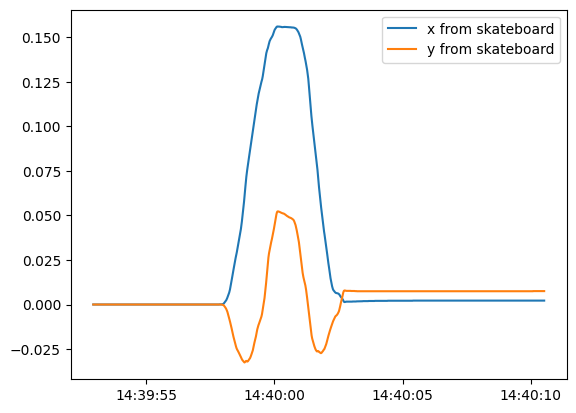

In [106]:
plt.plot(df["time"], df["x2"], label="x from skateboard")
plt.plot(df["time"], df["y2"], label="y from skateboard")
plt.legend()
# plt.plot(df["time"], df["theta"], label="e_rl")

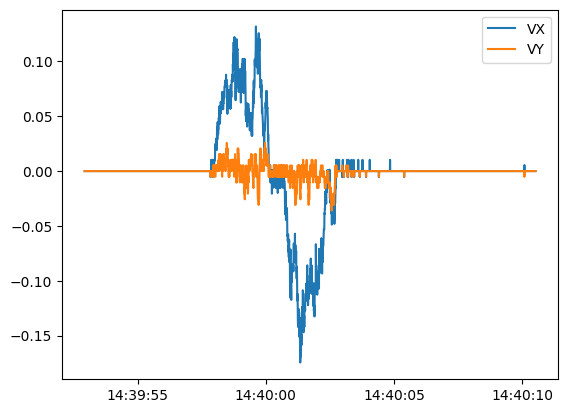

In [107]:
plt.plot(df["time"], df["vx"], label="VX")
plt.plot(df["time"], df["vy"], label="VY")
plt.legend()

In [108]:
sk_df = df[["time", "e_t", "e_rr", "e_rl"]]

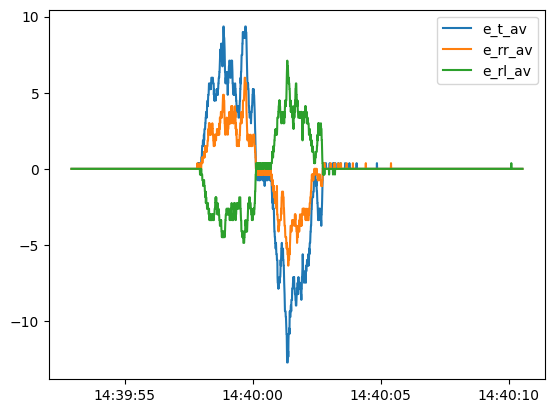

In [109]:
plt.plot(df["time"], df["e_t_av"], label="e_t_av")
plt.plot(df["time"], df["e_rr_av"], label="e_rr_av")
plt.plot(df["time"], df["e_rl_av"], label="e_rl_av")
plt.legend()

In [110]:
# type in marker details
_xm = get_marker_name(4) # sk33
_ym = get_marker_name(3)
_om = get_marker_name(1)

In [111]:
# mocap data
_mocap_df, st_time = read_rigid_body_csv(os.path.join(_base_pth, _folder_name.split("_")[0] ,_folder_name + ".csv"))
_mocap_df = add_datetime_col(_mocap_df, st_time, "seconds")

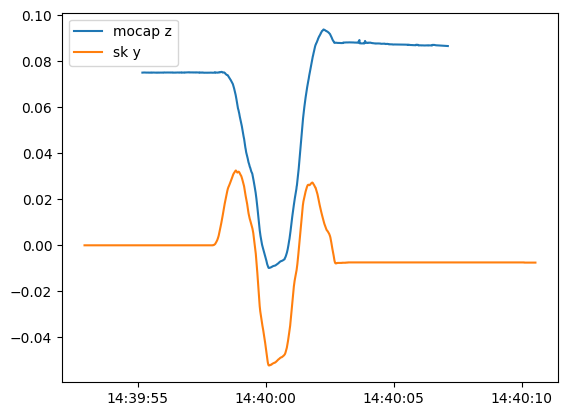

In [112]:
# plt.plot(_mocap_df.m2_x, label="x")
plt.plot(_mocap_df["time"], _mocap_df[_om["z"]], label="mocap z")
plt.plot(df["time"], -df["y2"], label="sk y")

# plt.plot(df["w"], label="theta")
plt.legend()

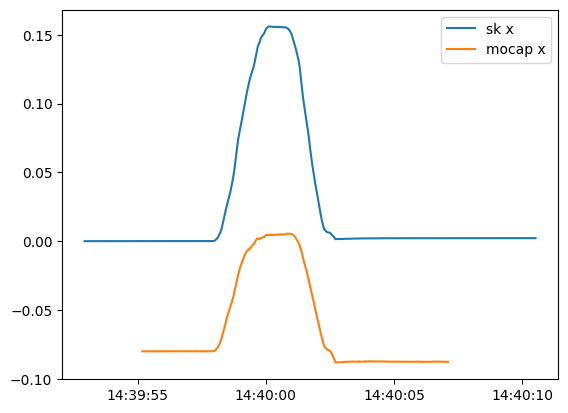

In [113]:
# plt.plot(_mocap_df.m2_x, label="x")
# plt.plot(_mocap_df["time"][:10000], _mocap_df[_om["x"]][:10000], label="mocap x")
# plt.plot(df["time"][:10000], -df["x"][:10000], label="vx")
plt.plot(df["time"], df["x2"], label="sk x")
plt.plot(_mocap_df["time"], -_mocap_df[_om["x"]], label="mocap x")


# plt.plot(df["w"], label="theta")
plt.legend()

In [114]:
"""
checking position
defining initial frame of reference
"""

xvec = [_mocap_df[_xm["x"]].iloc[0], _mocap_df[_xm["y"]].iloc[0], _mocap_df[_xm["z"]].iloc[0]]
xvec = np.array(xvec).reshape(3,1)

yvec = [_mocap_df[_ym["x"]].iloc[0], _mocap_df[_ym["y"]].iloc[0], _mocap_df[_ym["z"]].iloc[0]]
yvec = np.array(yvec).reshape(3,1)

org = [_mocap_df[_om["x"]].iloc[0], _mocap_df[_om["y"]].iloc[0], _mocap_df[_om["z"]].iloc[0]]
org = np.array(org).reshape(3,1)

v1 = xvec - org  # v1
v2 = yvec - org  # v2

vxnorm = v1 / np.linalg.norm(v1)

vycap = v2 - (vxnorm.T @ v2) * vxnorm
vynorm = vycap / np.linalg.norm(vycap)

vznorm = np.cross(vynorm.T[0], vxnorm.T[0]).reshape(3, 1)
rotMat = np.hstack((vxnorm, vynorm, vznorm)) # rotation matrix

In [115]:
@njit
def apply_rot_mat(mc_val, rotMat, org):
    return (rotMat.T @ (mc_val - org)).T[0]


In [116]:
# This cell is optimized to run faster using polars
_mc_df = _mocap_df[["time", _om["x"], _om["y"], _om["z"]]].copy()
_mc_df = _mc_df.rename(columns={_om["x"]: "x", _om["y"]: "y", _om["z"]: "z"})
# _mc_df = _mc_df.astype({"x": np.float64, "y": np.float64, "z": np.float64})

_mc_pl_df = pl.from_pandas(_mc_df)

my_dict = {"x":[],"y":[],"z":[]}

for i in tqdm(range(len(_mc_df))):
    _x, _y, _z = apply_rot_mat(_mc_pl_df[i, 1:].to_numpy().T, rotMat, org)
    my_dict["x"].append(_x)
    my_dict["y"].append(_y)
    my_dict["z"].append(_z)	

_mc_df["x"] = my_dict["x"]
_mc_df["y"] = my_dict["y"]
_mc_df["z"] = my_dict["z"]

100%|██████████| 1193/1193 [00:00<00:00, 2066.27it/s]


In [117]:
# This cell is optimized to run faster using polars

# calculate rotation matrix from xvec, zvec, org
_m_df = _mocap_df.copy()
_m_df = pl.from_pandas(_m_df)

_rotmat_i = []
for i in tqdm(range(len(_m_df))):
    
    _x_vec = _m_df[[_xm["x"], _xm["y"], _xm["z"]]][i, :].to_numpy().T
    _org = _m_df[[_om["x"], _om["y"], _om["z"]]][i, :].to_numpy().T
    _y_vec = _m_df[[_ym["x"], _ym["y"], _ym["z"]]][i, :].to_numpy().T

    _rotmat_i.append(calculate_rotmat_from_xyo(_x_vec, _y_vec, _org))
# calculating del rotmat for mc
_del_r = []
for i in tqdm(range(len(_rotmat_i))):
    _del_r.append(_rotmat_i[i].T@_rotmat_i[0])

# calculating angle for mc
_theta_x = []
_theta_y = []
_theta_z = []

for i in tqdm(_del_r):
    _theta_x.append(np.arctan2(i[2,1], i[2,2]))
    _theta_y.append(np.arctan2(-i[2,0], np.sqrt(i[2,1]**2 + i[2,2]**2)))
    _theta_z.append(np.arctan2(i[1,0], i[0,0]))
    
_theta_x = np.array(_theta_x)
_theta_y = np.array(_theta_y)
_theta_z = np.array(_theta_z)

# converting them to degrees
_theta_x = np.rad2deg(_theta_x)
_theta_y = np.rad2deg(_theta_y)
_theta_z = np.rad2deg(_theta_z)


100%|██████████| 1193/1193 [00:00<00:00, 198871.45it/s]


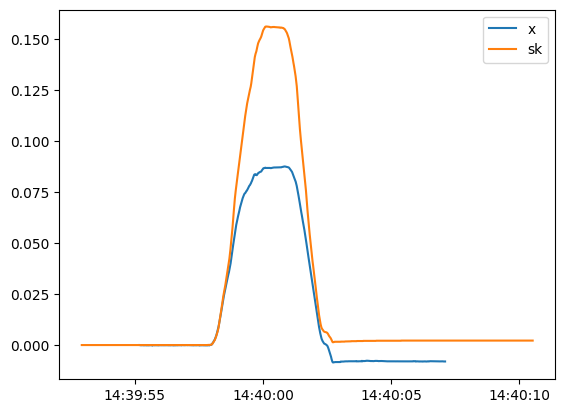

In [122]:
plt.plot(_mocap_df["time"], _mc_df["x"], label="x")
plt.plot(df["time"], df["x2"], label="sk")
plt.legend()

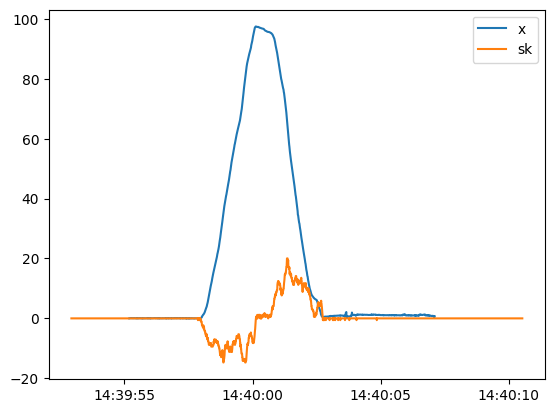

In [130]:
plt.plot(_mocap_df["time"], _theta_z, label="x")
plt.plot(df["time"], np.rad2deg(-df["w2"]), label="sk")
plt.legend()

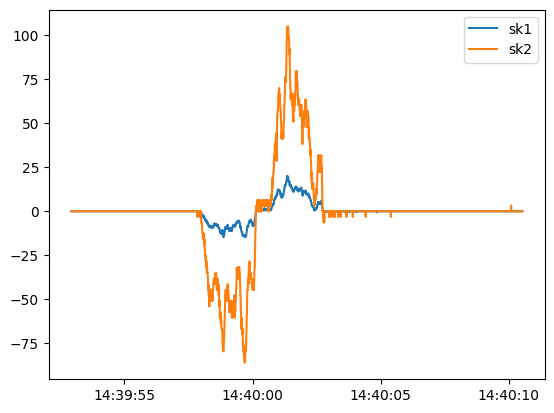

In [132]:
plt.plot(df["time"], np.rad2deg(-df["w2"]), label="sk1")
plt.plot(df["time"], np.rad2deg(df["w"]), label="sk2")
plt.legend()

